In [1]:
!conda install -c conda-forge --yes lifelines
!pip install -U pandas-profiling

Solving environment: done

# All requested packages already installed.



# DGCCA clustering

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pickle
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from lifelines import KaplanMeierFitter

## preset globals

In [2]:
CANCER = 'BRCA'
# DATA_DIR = '../data/TCGA_{}/DGCCA/'.format(CANCER)
# MODEL = 'DGCCA'
# EXP = 'exp1'
# INC_MISSING = True

# if not os.path.exists('./../../results/{}/{}/models/{}'.format(CANCER,MODEL,EXP)):
#     os.makedirs('./../../results/{}/{}/models/{}'.format(CANCER,MODEL,EXP))
    
# if not os.path.exists('./../../results/{}/{}/embeddings/{}'.format(CANCER,MODEL,EXP)):
#     os.makedirs('./../../results/{}/{}/embeddings/{}'.format(CANCER,MODEL,EXP))
    
# if not os.path.exists('./../../results/{}/{}/clustering/{}'.format(CANCER,MODEL,EXP)):
#     os.makedirs('./../../results/{}/{}/clustering/{}'.format(CANCER,MODEL,EXP))
    
# if not os.path.exists('./../../results/{}/{}/univcoxph/{}'.format(CANCER,MODEL,EXP)):
#     os.makedirs('./../../results/{}/{}/univcoxph/{}'.format(CANCER,MODEL,EXP))
    

In [3]:
id_mapping = pd.read_csv('../../data/TCGA_{}/methyl_rnaseq_mirna_minmax_idmapping.tsv'.format(CANCER), sep='\t')

In [4]:
id_mapping

,sample,index
1,TCGA-3C-AAAU-01,1
2,TCGA-3C-AALI-01,2
3,TCGA-3C-AALJ-01,3
4,TCGA-3C-AALK-01,4
5,TCGA-4H-AAAK-01,5
...,...,...
1229,TCGA-WT-AB44-01,1229
1230,TCGA-XX-A899-01,1230
1231,TCGA-XX-A89A-01,1231
1232,TCGA-Z7-A8R5-01,1232


In [14]:
b = np.load('../examples/final_embedding/final_embedding.npz')
embedding = b['arr_0']
subtypes = pd.read_csv('./../../data/TCGASubtype.20170308.tsv', sep='\t')
embedding_df = pd.DataFrame(embedding)
embedding_df.index = id_mapping['sample']
embedding_df = embedding_df.rename(columns={k:'DGCCA_'+str(k+1) for k in embedding_df.columns})

In [15]:
embedding_df

,DGCCA_1,DGCCA_2,DGCCA_3,DGCCA_4,DGCCA_5,DGCCA_6,DGCCA_7,DGCCA_8,DGCCA_9,DGCCA_10,...,DGCCA_216,DGCCA_217,DGCCA_218,DGCCA_219,DGCCA_220,DGCCA_221,DGCCA_222,DGCCA_223,DGCCA_224,DGCCA_225
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,0.000494,-0.046860,0.032792,-0.004265,0.024260,0.013513,0.012448,0.024710,-0.001376,0.025405,...,0.002415,0.023255,-0.009065,0.020328,0.005248,-0.011743,-0.008072,0.011319,0.019255,0.018175
TCGA-3C-AALI-01,-0.015829,-0.003747,0.049368,-0.013064,-0.023958,-0.017391,-0.019884,-0.021750,-0.010081,-0.015255,...,-0.030994,-0.021568,-0.022220,-0.020894,0.053162,-0.020591,0.051679,0.048915,-0.014391,0.048272
TCGA-3C-AALJ-01,-0.005624,-0.036077,0.054824,-0.016265,-0.002309,-0.001841,-0.000396,0.004631,-0.011895,0.007760,...,-0.013652,0.004710,-0.024388,-0.021973,0.026089,-0.022071,0.009734,0.020673,-0.024527,0.026849
TCGA-3C-AALK-01,0.015950,-0.035611,-0.026321,0.007293,0.026656,0.020304,0.028704,0.025051,0.006157,0.021669,...,0.034987,0.020635,0.016431,0.048466,-0.029664,0.001017,-0.033494,-0.023106,0.073231,-0.015769
TCGA-4H-AAAK-01,0.019102,0.080040,0.003446,0.003274,-0.007265,0.006102,-0.016222,0.015172,0.005155,-0.006392,...,-0.036153,0.003705,-0.046624,-0.011883,0.008879,0.082428,-0.002284,0.001646,-0.005075,0.002637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,0.039506,-0.059194,0.006873,-0.020440,-0.060089,-0.008794,-0.100170,-0.029980,0.108190,0.016501,...,0.022578,0.108534,-0.113127,0.023729,-0.146972,0.052610,-0.122218,0.003171,-0.068451,-0.018588
TCGA-XX-A899-01,-0.020675,0.005895,0.003710,0.004291,0.057808,0.034624,0.068143,0.020199,-0.026928,-0.027366,...,-0.016652,0.000405,0.005011,-0.043550,0.028081,0.040259,-0.038448,0.021558,0.039076,0.059503
TCGA-XX-A89A-01,-0.006956,0.025159,-0.002727,0.008690,-0.024345,-0.051278,-0.032581,-0.028292,-0.043621,0.024976,...,0.019421,0.020623,-0.021375,-0.028766,-0.003151,0.020267,-0.008772,0.008221,-0.006480,-0.021231


In [16]:
subtypes

,sampleID,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected
0,TCGA-OR-A5J1-01,steroid-phenotype-high+proliferation,CIMP-high,NaN,miRNA_1,Quiet,COC3,C1A,ACC.CIMP-high
1,TCGA-OR-A5J2-01,steroid-phenotype-high+proliferation,CIMP-low,1,miRNA_1,Noisy,COC3,C1A,ACC.CIMP-low
2,TCGA-OR-A5J3-01,steroid-phenotype-high,CIMP-intermediate,3,miRNA_6,Chromosomal,COC2,C1A,ACC.CIMP-intermediate
3,TCGA-OR-A5J4-01,NaN,CIMP-high,NaN,miRNA_6,Chromosomal,NaN,NaN,ACC.CIMP-high
4,TCGA-OR-A5J5-01,steroid-phenotype-high,CIMP-intermediate,NaN,miRNA_2,Chromosomal,COC2,C1A,ACC.CIMP-intermediate
...,...,...,...,...,...,...,...,...,...
7729,TCGA-ND-A4WA-01,2,NaN,NaN,NaN,NaN,NaN,NaN,UCS.2
7730,TCGA-NG-A4VU-01,1,NaN,NaN,NaN,NaN,NaN,NaN,UCS.1
7731,TCGA-QN-A5NN-01,2,NaN,NaN,NaN,NaN,NaN,NaN,UCS.2
7732,TCGA-NF-A5CP-01,2,NaN,NaN,NaN,NaN,NaN,NaN,UCS.2


## PCA

In [23]:
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embedding)
#print(embedding_pca)
id_mapping['PCA_1'] = embedding_pca[:,0]
id_mapping['PCA_2'] = embedding_pca[:,1]
sampleWithSubtypes = id_mapping.merge(subtypes, left_on='sample', right_on='sampleID')

In [24]:
sampleWithSubtypes

,sample,index,PCA_1,PCA_2,sampleID,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected
0,TCGA-3C-AAAU-01,1,-0.009815,0.024229,TCGA-3C-AAAU-01,LumA,NaN,NaN,NaN,NaN,NaN,NaN,BRCA.LumA
1,TCGA-3C-AALI-01,2,-0.061679,-0.025383,TCGA-3C-AALI-01,Her2,NaN,NaN,NaN,NaN,NaN,NaN,BRCA.Her2
2,TCGA-3C-AALJ-01,3,-0.051333,-0.009370,TCGA-3C-AALJ-01,LumB,NaN,NaN,NaN,NaN,NaN,NaN,BRCA.LumB
3,TCGA-3C-AALK-01,4,0.067526,0.046897,TCGA-3C-AALK-01,LumA,NaN,NaN,NaN,NaN,NaN,NaN,BRCA.LumA
4,TCGA-4H-AAAK-01,5,0.016810,0.005191,TCGA-4H-AAAK-01,LumA,NaN,NaN,NaN,NaN,NaN,NaN,BRCA.LumA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,TCGA-WT-AB44-01,1229,0.041936,0.065746,TCGA-WT-AB44-01,LumA,NaN,NaN,NaN,NaN,NaN,NaN,BRCA.LumA
1214,TCGA-XX-A899-01,1230,-0.035193,0.006128,TCGA-XX-A899-01,LumA,NaN,NaN,NaN,NaN,NaN,NaN,BRCA.LumA
1215,TCGA-XX-A89A-01,1231,-0.057700,-0.009516,TCGA-XX-A89A-01,LumA,NaN,NaN,NaN,NaN,NaN,NaN,BRCA.LumA
1216,TCGA-Z7-A8R5-01,1232,0.005142,0.058240,TCGA-Z7-A8R5-01,LumA,NaN,NaN,NaN,NaN,NaN,NaN,BRCA.LumA


<AxesSubplot:xlabel='PCA_1', ylabel='PCA_2'>

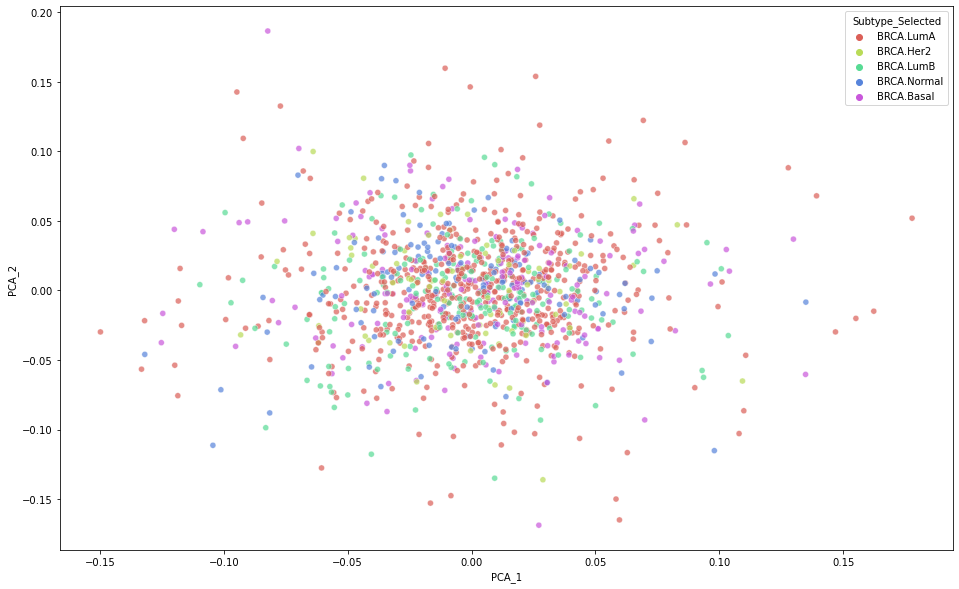

In [25]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PCA_1", y="PCA_2",
    hue="Subtype_Selected",
    palette=sns.color_palette("hls", len(sampleWithSubtypes.Subtype_Selected.unique())),
    data=sampleWithSubtypes,
    legend="full",
    alpha=0.7
)

## T-SNE

In [26]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
embedding_tsne = tsne.fit_transform(embedding)
id_mapping['TSNE_1'] = embedding_tsne[:,0]
id_mapping['TSNE_2'] = embedding_tsne[:,1]
sampleWithSubtypes = id_mapping.merge(subtypes, left_on='sample', right_on='sampleID')

/home/pdutta/anaconda3/envs/dgcca/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/pdutta/anaconda3/envs/dgcca/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1233 samples in 0.000s...
[t-SNE] Computed neighbors for 1233 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1233
[t-SNE] Computed conditional probabilities for sample 1233 / 1233
[t-SNE] Mean sigma: 0.174051
[t-SNE] KL divergence after 250 iterations with early exaggeration: 133.443756
[t-SNE] KL divergence after 1400 iterations: 2.428635


<AxesSubplot:xlabel='TSNE_1', ylabel='TSNE_2'>

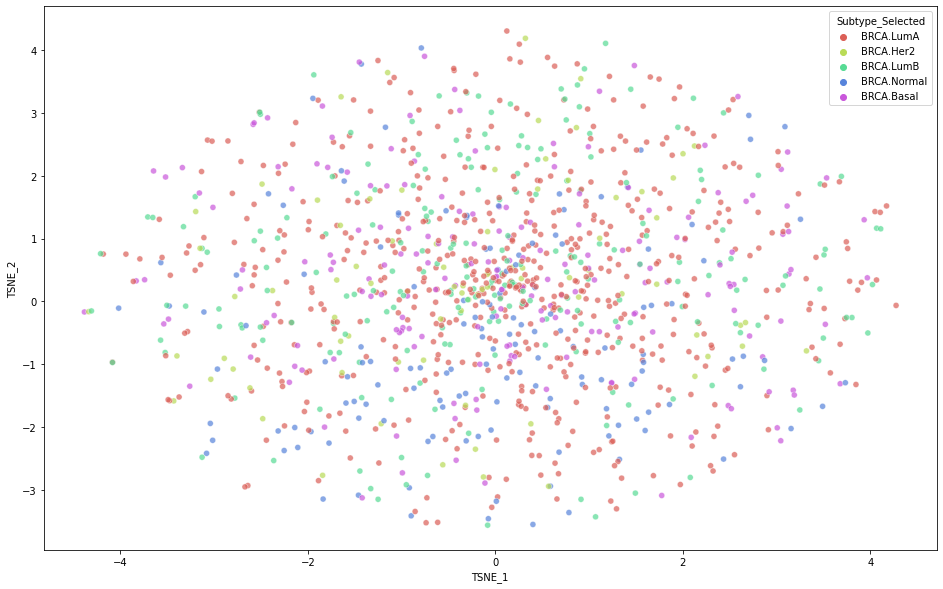

In [27]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="TSNE_1", y="TSNE_2",
    hue="Subtype_Selected",
    palette=sns.color_palette("hls", len(sampleWithSubtypes.Subtype_Selected.unique())),
    data=sampleWithSubtypes,
    legend="full",
    alpha=0.7
)

## Univariate CoxPH model (done in R)

## k-means clustering

Initialization complete
Iteration 0, inertia 1113.7239990234375
Iteration 1, inertia 448.7492980957031
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 635.2567138671875
Iteration 1, inertia 448.707763671875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 589.5715942382812
Iteration 1, inertia 448.5450134277344
Iteration 2, inertia 448.51995849609375
Iteration 3, inertia 448.5048828125
Iteration 4, inertia 448.4997863769531
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 688.9634399414062
Iteration 1, inertia 448.483154296875
Iteration 2, inertia 448.4081115722656
Iteration 3, inertia 448.35711669921875
Iteration 4, inertia 448.32989501953125
Iteration 5, inertia 448.322265625
Iteration 6, inertia 448.3175048828125
Iteration 7, inertia 448.3130187988281
Iteration 8, inertia 448.3105163574219
Iteration 9, inertia 448.3091125488281
Iteration 10, inertia 448.3085

Initialization complete
Iteration 0, inertia 656.149169921875
Iteration 1, inertia 447.81170654296875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 681.30322265625
Iteration 1, inertia 447.5493469238281
Iteration 2, inertia 447.3653259277344
Iteration 3, inertia 447.3006591796875
Iteration 4, inertia 447.2547302246094
Iteration 5, inertia 447.24609375
Iteration 6, inertia 447.24273681640625
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 643.2227783203125
Iteration 1, inertia 447.6337890625
Iteration 2, inertia 447.6148681640625
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 674.4824829101562
Iteration 1, inertia 447.672607421875
Iteration 2, inertia 447.5539245605469
Iteration 3, inertia 447.5232849121094
Iteration 4, inertia 447.5152893066406
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 534.5914306640625
Iter

KeyboardInterrupt: Interrupted by user

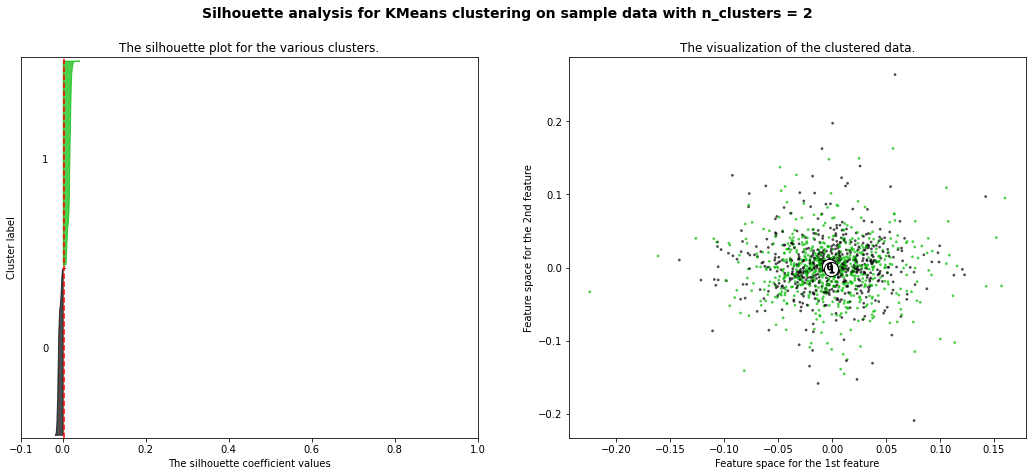

In [31]:
# using full embedding
# clustering for k = 2 to 6

models = []
clus_res = {}
clus_res['k'] = []
clus_res['silhouette'] = []
clus_res['calinski_harabasz'] = []

for k in range(2,7,1):
    model = KMeans(n_clusters=k,
                   n_init=100,
                   max_iter=2000,
                   verbose=1,
                   random_state=123,
                 ).fit(embedding)
    labels = model.labels_
    sil_score = metrics.silhouette_score(embedding, labels, metric='euclidean')
    ch_score = metrics.calinski_harabasz_score(embedding, labels)
    
    print('k = {}, silhouette width = {}, calinski-harabasz score = {}'.format(k,
                                                                              sil_score,
                                                                              ch_score))
    
    clus_res['k'].append(k)
    clus_res['silhouette'].append(sil_score)
    clus_res['calinski_harabasz'].append(ch_score)
    input()
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(embedding) + (k + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     cluster_labels = clusterer.fit_predict(X)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(embedding, labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / k)
    ax2.scatter(embedding[:, 0], embedding[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = model.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()

In [75]:
# load coxph filtered embedding
embedding_coxph_df = pd.read_csv('./../../results/{}/{}/embeddings/{}/{}_embeddings_coxph.csv'.format(CANCER,MODEL,EXP,MODEL), index_col=0)

In [76]:
# include missing?
if not INC_MISSING:
    common_sample = pd.read_csv('./../../data/TCGA_{}/methyl_rnaseq_mirna_minmax_common_sample.csv'.format(CANCER), index_col=0)
    embedding_coxph_df = embedding_coxph_df.reset_index()
    embedding_coxph_df = embedding_coxph_df[embedding_coxph_df['index'].isin(common_sample['x'])]
    id_mapping = id_mapping[id_mapping['sample'].isin(embedding_coxph_df['index'])]
    embedding_coxph_df = embedding_coxph_df.set_index('index', drop=True)
    embedding_coxph = embedding_coxph_df.values[:,1:]
else:
    embedding_coxph = embedding_coxph_df.values

# embedding_coxph_df.to_csv('./../../results/{}/{}/embeddings/{}/{}_embeddings_coxph.csv'.format(CANCER,MODEL,EXP,MODEL))

k = 2, silhouette width = 0.08952263173048668, calinski-harabasz score = 59.21395018012403, time = 0.13642215728759766
k = 3, silhouette width = 0.08409932133354447, calinski-harabasz score = 54.29404199500066, time = 0.1602001190185547
k = 4, silhouette width = 0.0793239375025438, calinski-harabasz score = 50.1483602575554, time = 0.15769481658935547
k = 5, silhouette width = 0.07525665897497008, calinski-harabasz score = 47.32040279267753, time = 0.15516304969787598
k = 6, silhouette width = 0.07147462881395517, calinski-harabasz score = 45.005302068016306, time = 0.16124820709228516


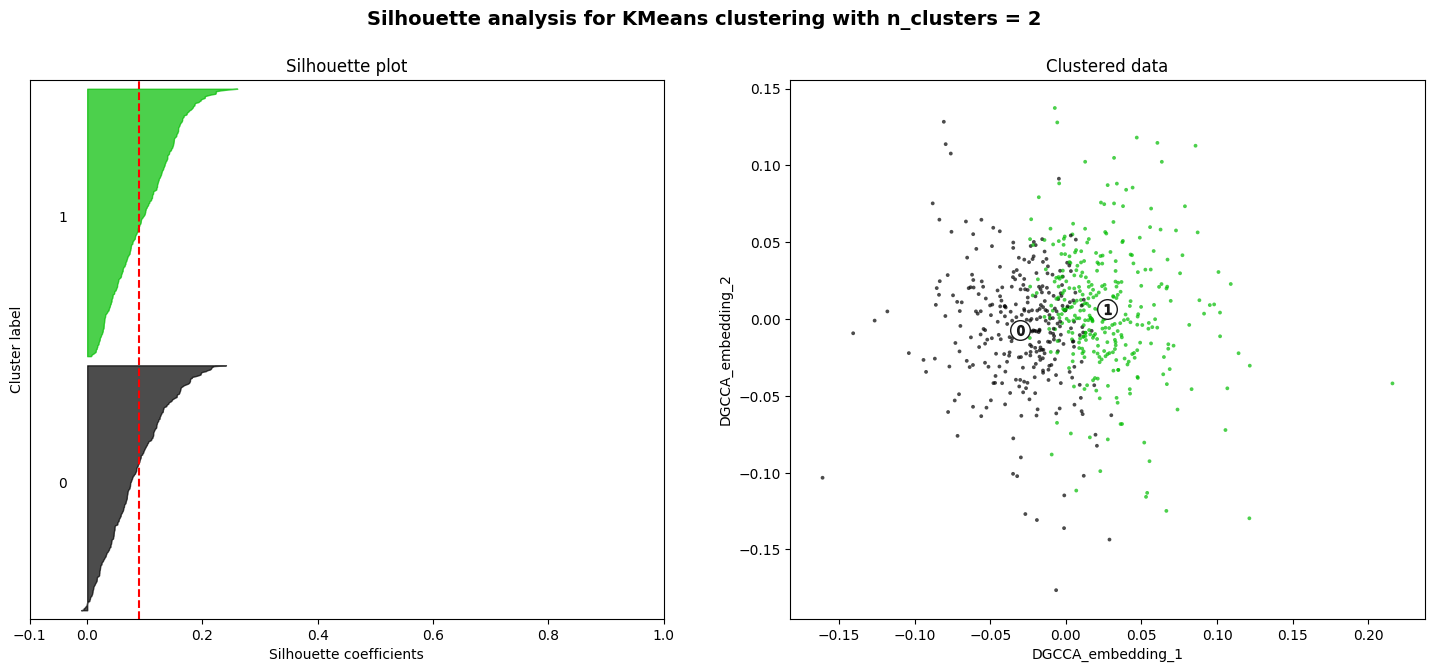

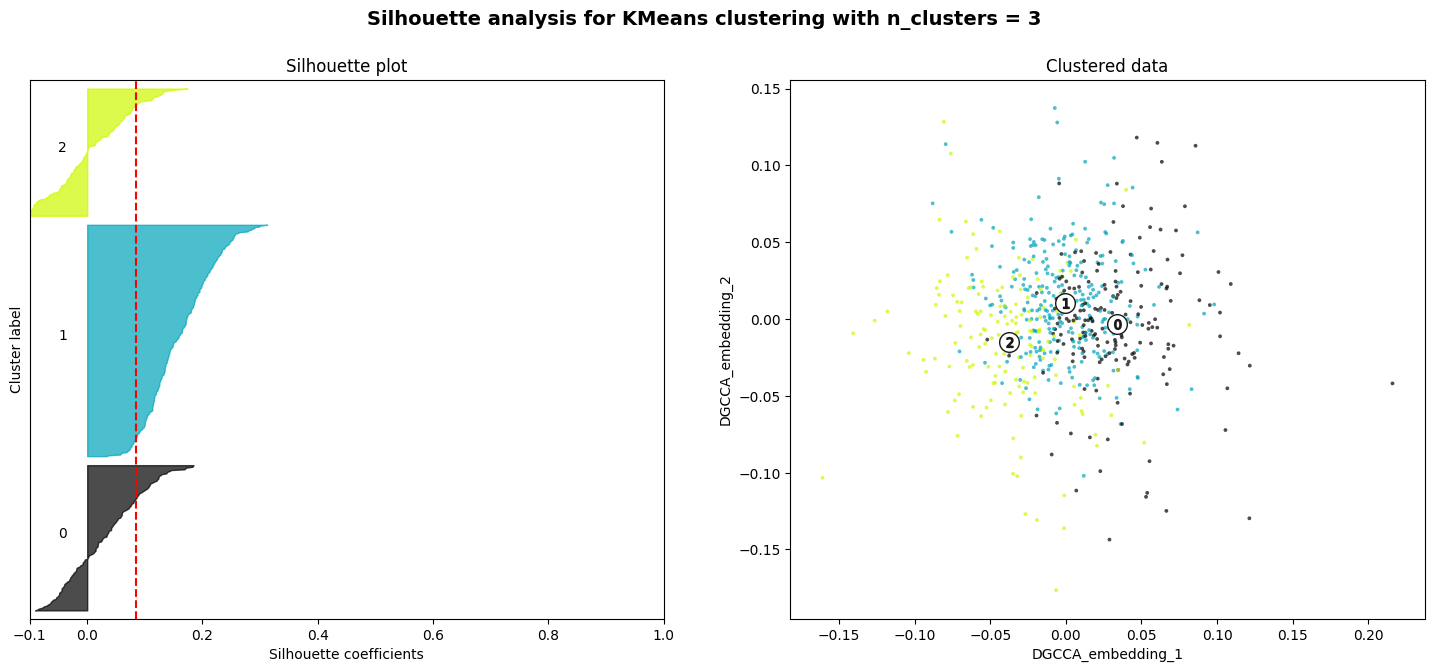

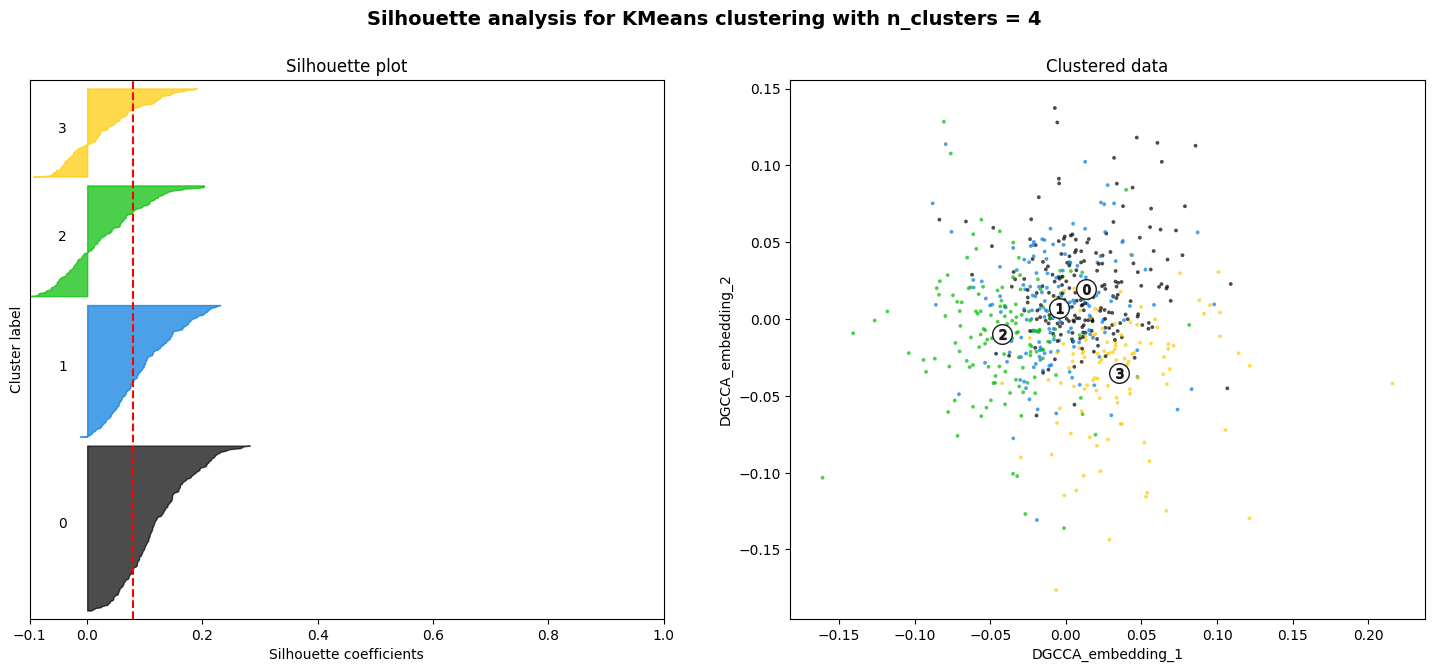

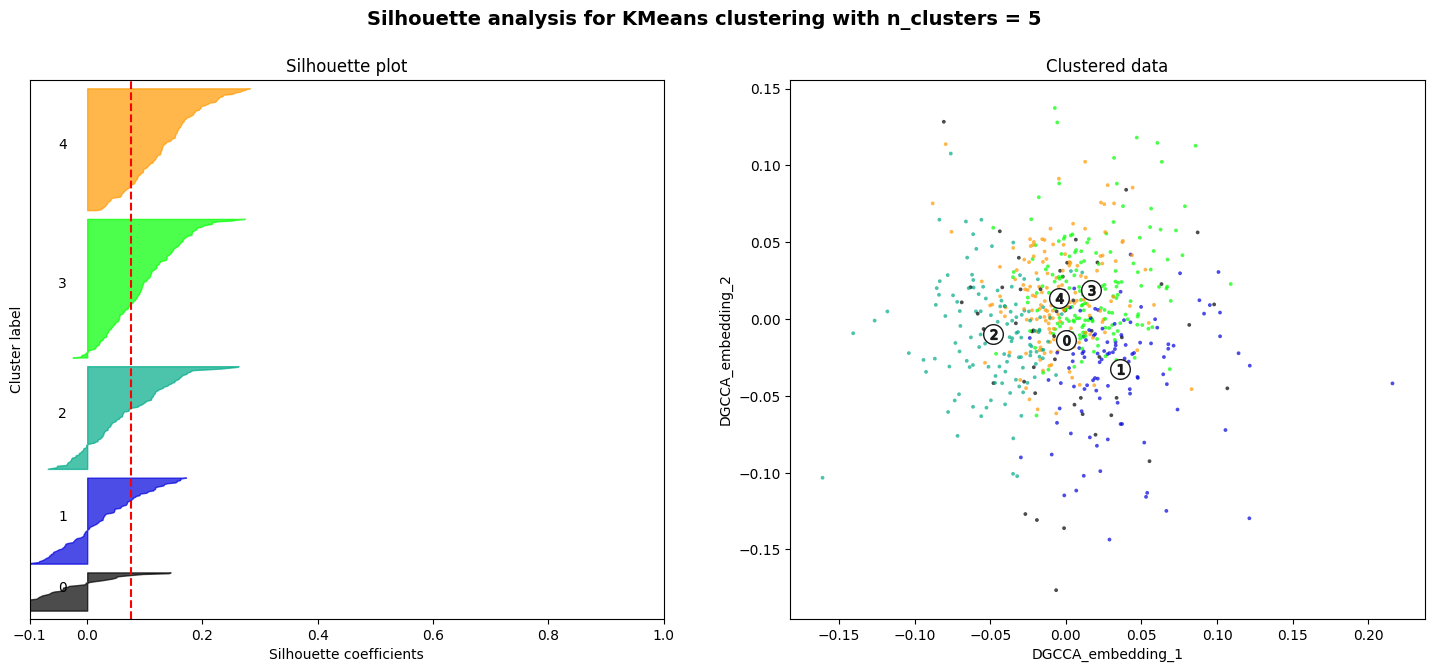

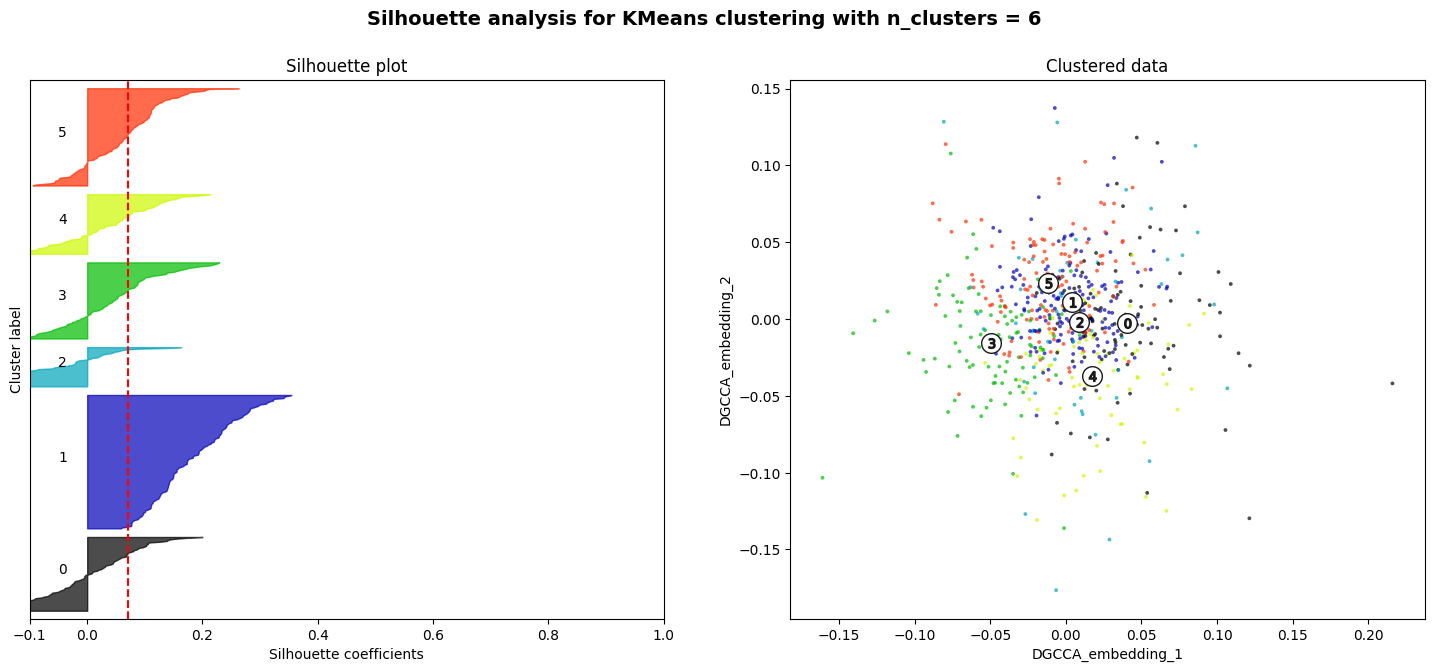

In [77]:
# using univariate coxph-filtered embeddings
# clustering for k = 2 to 6

models = []

clus_res = {}
clus_res['k'] = []
clus_res['silhouette'] = []
clus_res['calinski_harabasz'] = []


for k in range(2,7,1):
    t1 = time.time()
    model = KMeans(n_clusters=k,
                   n_init=100,
                   max_iter=2000,
                   verbose=1,
                   random_state=123,
                   n_jobs=-1
                 ).fit(embedding_coxph)
    labels = model.labels_
    sil_score = metrics.silhouette_score(embedding_coxph, labels, metric='euclidean')
    ch_score = metrics.calinski_harabasz_score(embedding_coxph, labels)
    t2 = time.time()
    print('k = {}, silhouette width = {}, calinski-harabasz score = {}, time = {}'.format(k,
                                                                              sil_score,
                                                                              ch_score,
                                                                              t2-t1))
    models.append(model)
    clus_res['k'].append(k)
    clus_res['silhouette'].append(sil_score)
    clus_res['calinski_harabasz'].append(ch_score)
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(embedding_coxph) + (k + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     cluster_labels = clusterer.fit_predict(X)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(embedding_coxph, labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("Silhouette coefficients")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / k)
    ax2.scatter(embedding_coxph[:, 0], embedding_coxph[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = model.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
        
#     ax2.set_ylim(-0.08177, -0.08178)
#     ax2.set_xlim(-0.08600, -0.086004)

    ax2.set_title("Clustered data")
    ax2.set_xlabel("DGCCA_embedding_1")
    ax2.set_ylabel("DGCCA_embedding_2")

    plt.suptitle(("Silhouette analysis for KMeans clustering "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

#     plt.savefig('./../../results/{}/{}/clustering/{}/kmeans_coxph_{}_embedding.png'.format(CANCER,MODEL,EXP,k))

In [63]:
0.12949800491333008+0.11819624900817871+0.12366056442260742+0.12672019004821777+0.12528753280639648

0.6233625411987305

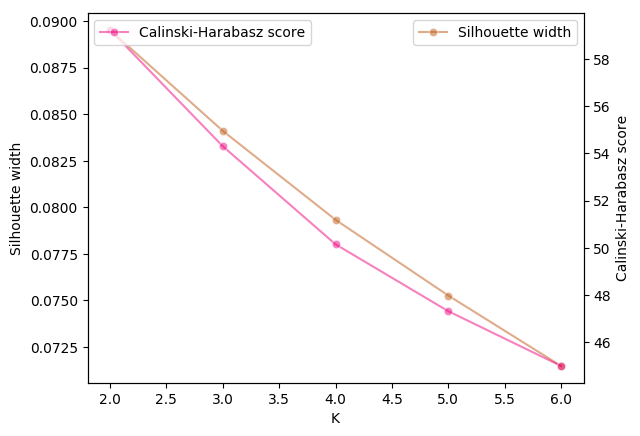

In [78]:
clus_res_df = pd.DataFrame(clus_res)
# clus_res_df = pd.melt(clus_res_df, id_vars='k')
sns.reset_defaults()
palette = iter(sns.color_palette("Accent_r",len(clus_res_df)))
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.lineplot(data=clus_res_df, x="k", y="silhouette", 
             marker = 'o', ax = ax1, color = next(palette), 
             label='Silhouette width', alpha =0.5) # plots the first set of data, and sets it to ax1. 
sns.lineplot(data=clus_res_df, x="k", y="calinski_harabasz", 
             marker = 'o', color = next(palette), ax = ax2, 
             label='Calinski-Harabasz score',alpha =0.5) # plots the second set, and sets to ax2. 

# these lines add the annotations for the plot. 
ax1.set_xlabel('K')
ax1.set_ylabel('Silhouette width')
ax2.set_ylabel('Calinski-Harabasz score')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.savefig('./../../results/{}/{}/clustering/{}/cluster_eval.png'.format(CANCER,MODEL,EXP)) # shows the plot. 

In [143]:
# with open('./../../results/LIHC/DGCCA/clustering/kmeans_results_coxph_embedding_exp12_epoch41.pkl', 'wb') as f:
#     pickle.dump(clus_res, f)
    
# with open('./../../results/LIHC/DGCCA/clustering/kmeans_models_coxph_embedding_exp12_epoch41.pkl', 'wb') as f:
#     pickle.dump(models, f)

In [435]:
id_mapping['DGCCA_cluster'] = models[4].labels_

In [79]:
id_mapping[['sample','DGCCA_cluster']].to_csv('./../../results/{}/{}/clustering/{}/cluster_assignment.csv'.format(CANCER,MODEL,EXP))

KeyError: "['DGCCA_cluster'] not in index"

In [81]:
id_mapping['DGCCA_cluster_2'] = models[0].labels_
id_mapping['DGCCA_cluster_3'] = models[1].labels_
id_mapping['DGCCA_cluster_4'] = models[2].labels_
id_mapping['DGCCA_cluster_5'] = models[3].labels_
id_mapping['DGCCA_cluster_6'] = models[4].labels_

In [82]:
id_mapping[['sample',
            'DGCCA_cluster_2',
            'DGCCA_cluster_3',
            'DGCCA_cluster_4',
            'DGCCA_cluster_5',
            'DGCCA_cluster_6'
           ]].to_csv('./../../results/{}/{}/clustering/{}/cluster_assignment.csv'.format(CANCER,MODEL,EXP))

In [66]:
models[0].labels_.shape

(438,)